# Setup

In [4]:
!pip install pacmap


  Using cached pacmap-0.8.0-py3-none-any.whl.metadata (14 kB)
Using cached pacmap-0.8.0-py3-none-any.whl (21 kB)


In [7]:
# ========================================
# IMPORTS FOR EDA
# ========================================
import os
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import Counter


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.express as px
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from pacmap import PaCMAP


In [8]:
# ========================================
# PATHS (Global)
# ========================================
train_path = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train')
val_path   = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid')
test_path  = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test')

# Function

In [9]:

# ========================================
# UTILS
# ========================================
def list_images(folder):
    exts = ('*.jpg','*.jpeg','*.png','*.tif')
    files = []
    for e in exts:
        files.extend(folder.rglob(e))
    return sorted(files)

def sample_images(file_list, n=9):
    return file_list[:n]

def show_image_grid(filepaths, cols=3, title=None, resize=(224,224)):
    rows = int(np.ceil(len(filepaths)/cols))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axs = axs.flatten()
    for ax, fp in zip(axs, filepaths):
        try:
            im = Image.open(fp).convert('RGB').resize(resize)
            ax.imshow(im)
            ax.set_title(fp.name, fontsize=9)
        except Exception as e:
            ax.text(0.5,0.5, f'ERR\n{e}', ha='center')
        ax.axis('off')
    for ax in axs[len(filepaths):]:
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()





# EDA

In [ ]:
# Data training sangat dikit, hanya 2000 yang membuat kita tidak bisa pakai model yang besar.

In [10]:
# ========================================
# SECTION 1 — FILE COUNTS & STRUCTURE
# ========================================
for label, p in [('train', train_path), ('valid', val_path), ('test', test_path)]:
    print(f"{label:5s}: {len(list_images(p)):5d} images — {p}")


train:  2000 images — /kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train
valid:   150 images — /kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid
test :   600 images — /kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test


In [ ]:
# Dataset sangat imbalanced, tidak bisa hanya pakai augmentasi biasa.

In [11]:
# ========================================
# SECTION 2 — COUNT BY LABEL (TRAIN)
# ========================================
classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
df_labels = pd.DataFrame([(c, len(list((train_path/c).glob('*')))) for c in classes],
                         columns=["Label","Count"])
df_labels

Label  Count
0              melanoma    374
1                 nevus   1372
2  seborrheic_keratosis    254

In [ ]:
# Rasio Aspek (Lebar/Tinggi) didominasi oleh dua kelompok utama:
# 1.50 (rasio 3:2): Mayoritas tertinggi, menunjukkan banyak gambar bersumber dari format fotografi standar.
# 1.33 (rasio 4:3): Kelompok signifikan kedua, menunjukkan sumber gambar dari format tampilan komputer/kamera lama.
# Implikasi: Dataset sebagian besar terdiri dari gambar persegi panjang non-standar (bukan 1:1). Dalam preprocessing, perubahan ukuran (resizing) lebih disarankan daripada pemotongan (cropping) untuk mencegah hilangnya detail lesi kulit.


# Tinggi gambar sangat bervariasi (dari 540 hingga 4459 piksel).
# Mayoritas: Terkonsentrasi di bawah 1500 piksel, dengan puncak terbesar (modus) di sekitar 600–800 piksel (mendekati nilai median 802).
# Variasi: Ada kelompok yang lebih kecil dan signifikan di sekitar 2500–3000 piksel, menunjukkan adanya sumber resolusi tinggi di antara dataset.
# Implikasi: Diperlukan resizing untuk memastikan konsistensi input model cnn.

Height — min/median/mean/max: 540 802.0 1486 4459
Width  — min/median/mean/max: 576 1024.0 2102 6708


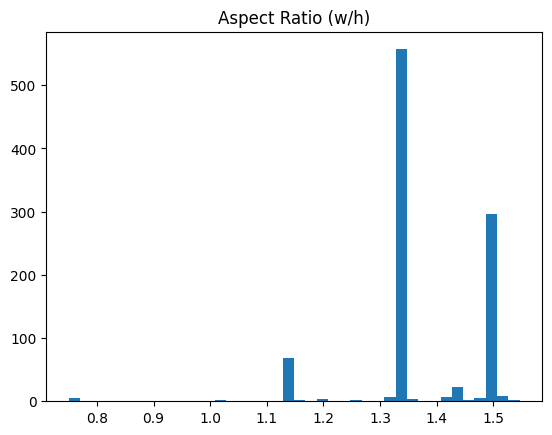

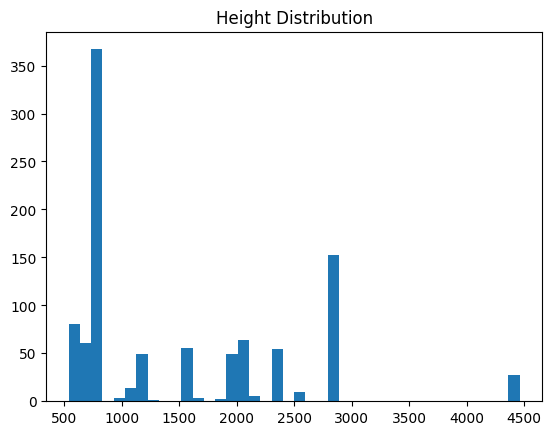

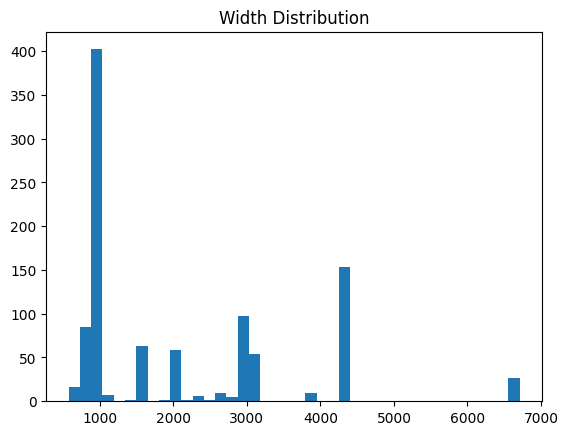

Mean (R,G,B): [181.80661164 152.04088204 140.59788052]
Std  (R,G,B): [27.60355227 32.68219864 38.29277981]


In [15]:
# ========================================
# SECTION 3 — IMAGE STATISTICS
# ========================================
def gather_image_stats(file_list, limit=None):
    file_list = file_list[:limit] if limit else file_list
    sizes, modes, means, stds = [], [], [], []
    
    for fp in file_list:
        try:
            im = Image.open(fp).convert('RGB')
            arr = np.array(im)
            sizes.append(arr.shape[:2])
            modes.append('RGB')
            means.append(arr.mean(axis=(0,1)))
            stds.append(arr.std(axis=(0,1)))
        except:
            pass
    return {
        'sizes': np.array(sizes),
        'modes': Counter(modes),
        'means': np.array(means),
        'stds': np.array(stds)
    }

train_files = list_images(train_path)
stats = gather_image_stats(train_files, limit=min(1000, len(train_files)))

if stats['sizes'].size:
    hs, ws = stats['sizes'][:,0], stats['sizes'][:,1]
    print("Height — min/median/mean/max:", hs.min(), np.median(hs), int(hs.mean()), hs.max())
    print("Width  — min/median/mean/max:", ws.min(), np.median(ws), int(ws.mean()), ws.max())

    plt.hist(ws/hs, bins=40); plt.title("Aspect Ratio (w/h)"); plt.show()
    plt.hist(hs, bins=40); plt.title("Height Distribution"); plt.show()
    plt.hist(ws, bins=40); plt.title("Width Distribution"); plt.show()

if stats['means'].size:
    print("Mean (R,G,B):", stats['means'].mean(axis=0))
    print("Std  (R,G,B):", stats['stds'].mean(axis=0))


In [ ]:
# nevus dan melanoma sangat mirip, akan susah dibedakan oleh model

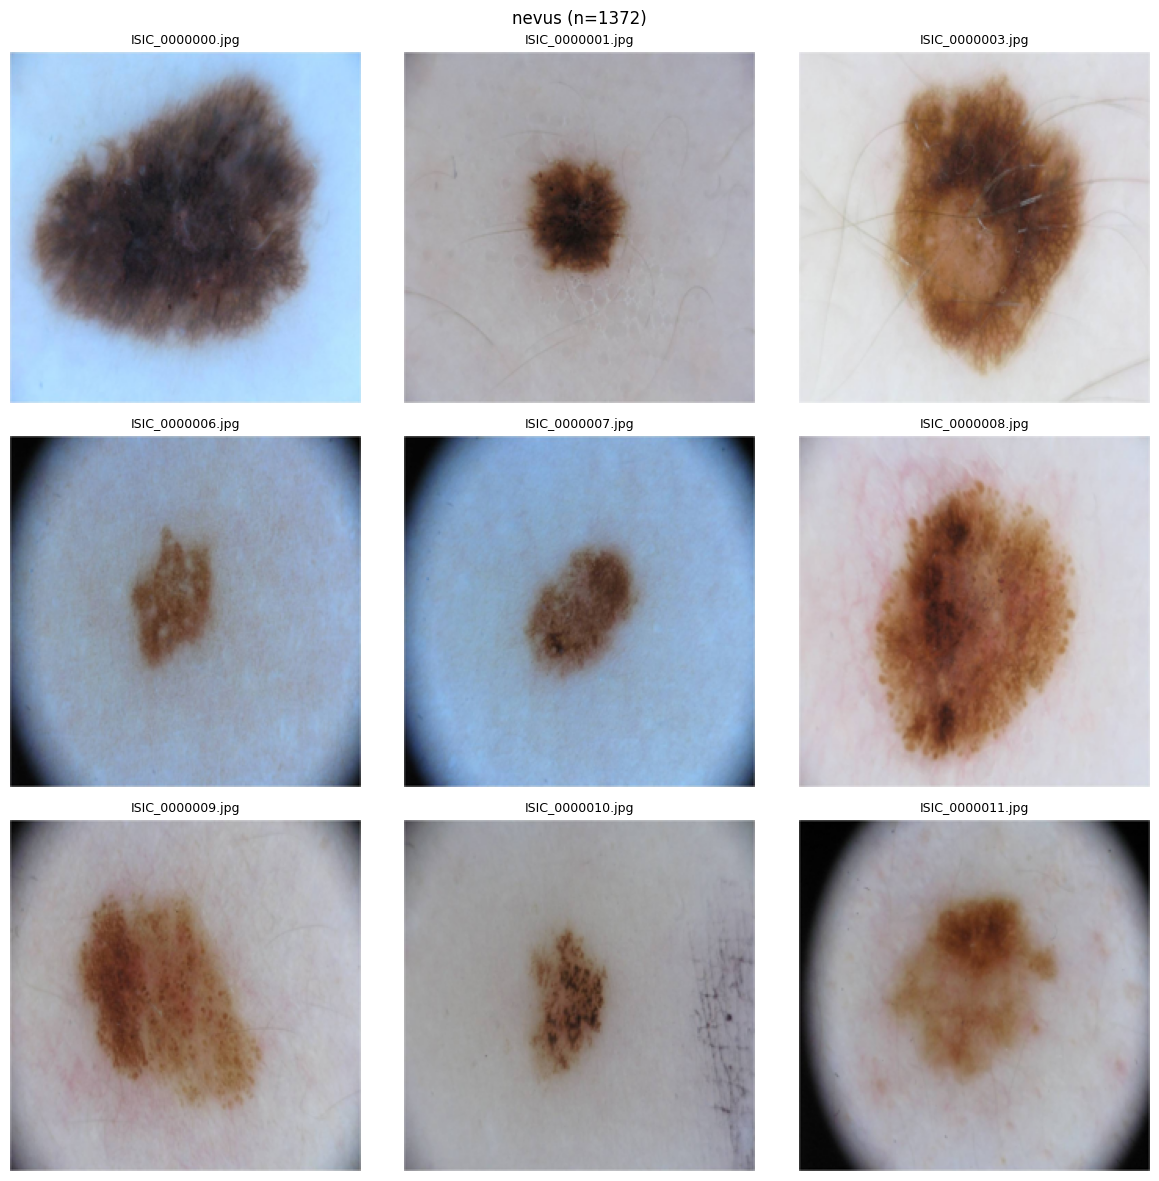

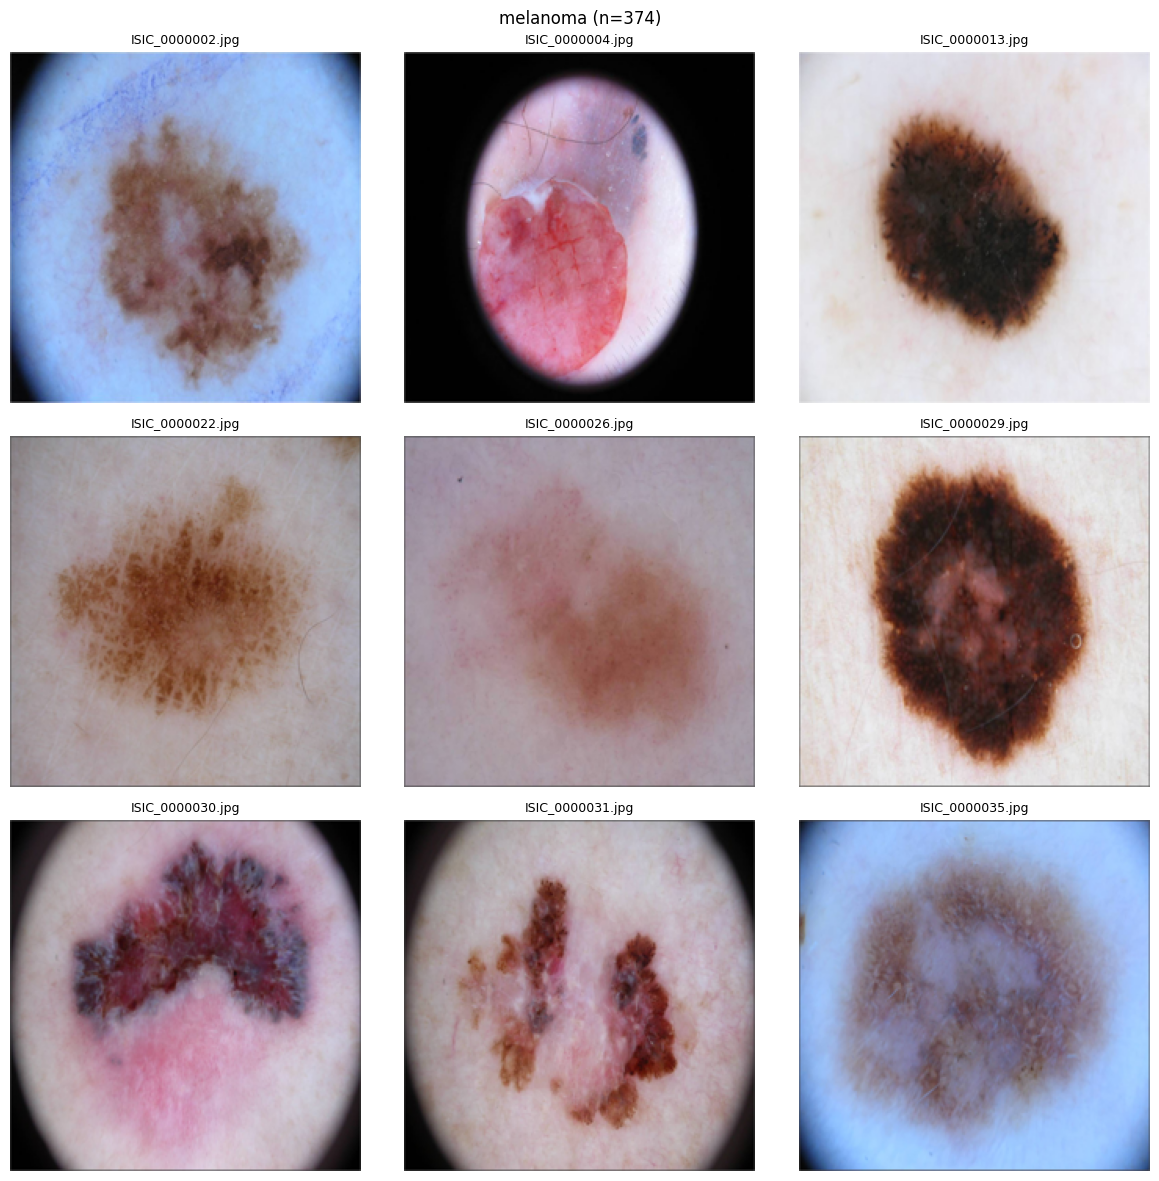

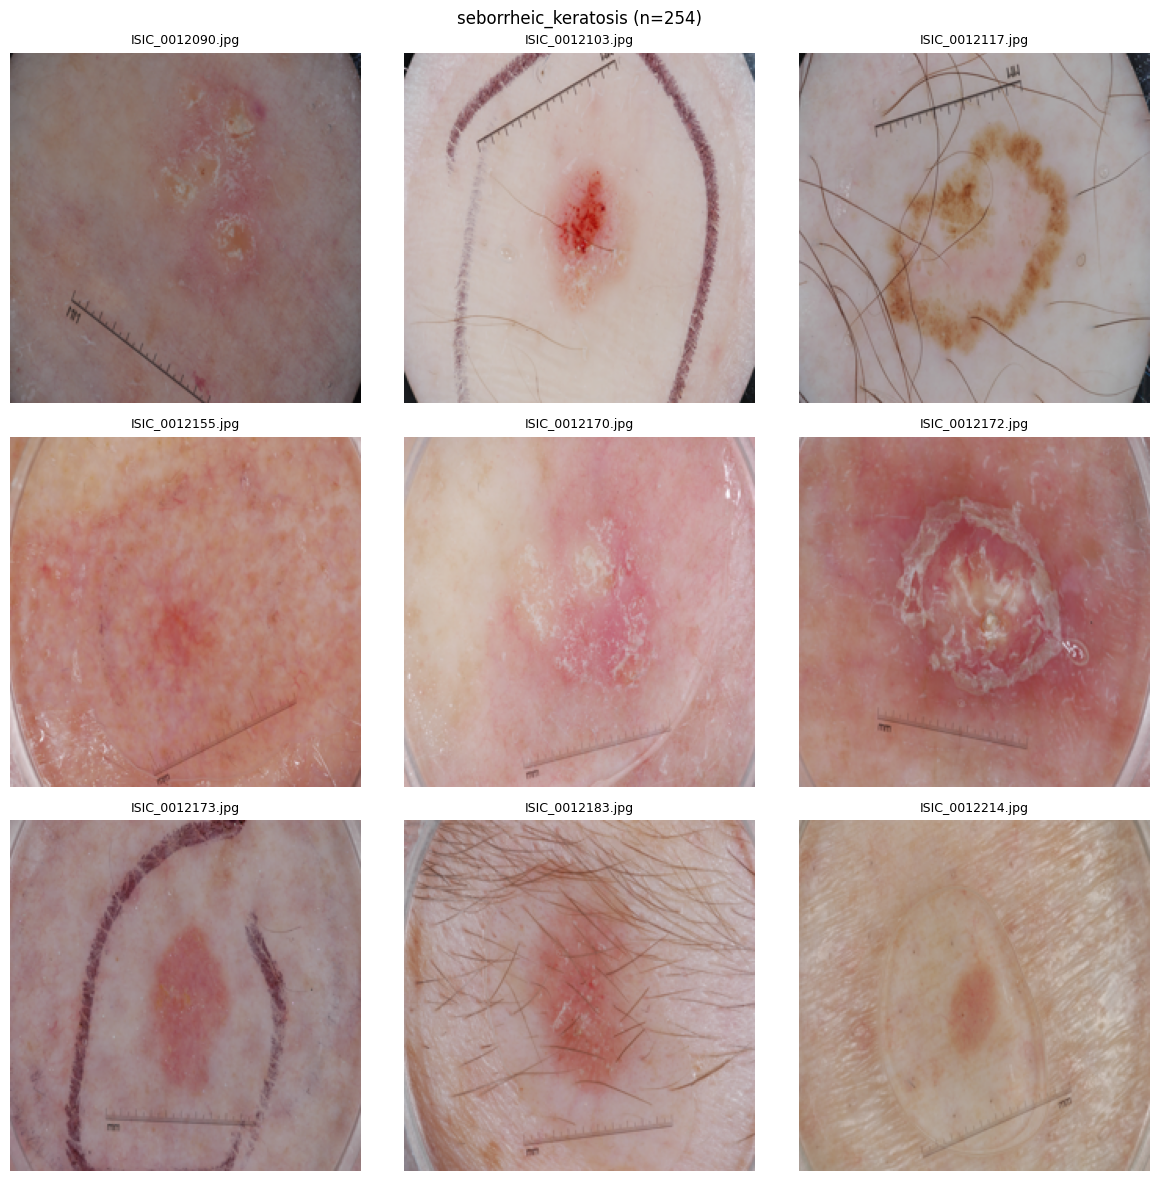

In [12]:
# ========================================
# SECTION 5 — DISPLAY CLASS SAMPLES
# ========================================
train_counts = {cls: len(list((train_path/cls).glob('*.jpg'))) for cls in classes}
top_classes = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)[:6]

for cls, _ in top_classes:
    fps = list_images(train_path/cls)
    show_image_grid(sample_images(fps, 9), title=f"{cls} (n={len(fps)})")

In [ ]:
# tidak ada corrupt images, nice

In [16]:
# ========================================
# SECTION 6 — CORRUPT CHECK
# ========================================
def find_corrupts(file_list, limit=500):
    corrupts = []
    for fp in file_list[:limit]:
        try:
            Image.open(fp).verify()
        except Exception as e:
            corrupts.append((fp, str(e)))
    return corrupts

corrupts = find_corrupts(train_files)
print(f"Corrupt Images: {len(corrupts)}")
print(corrupts[:10])


Corrupt Images: 0
[]


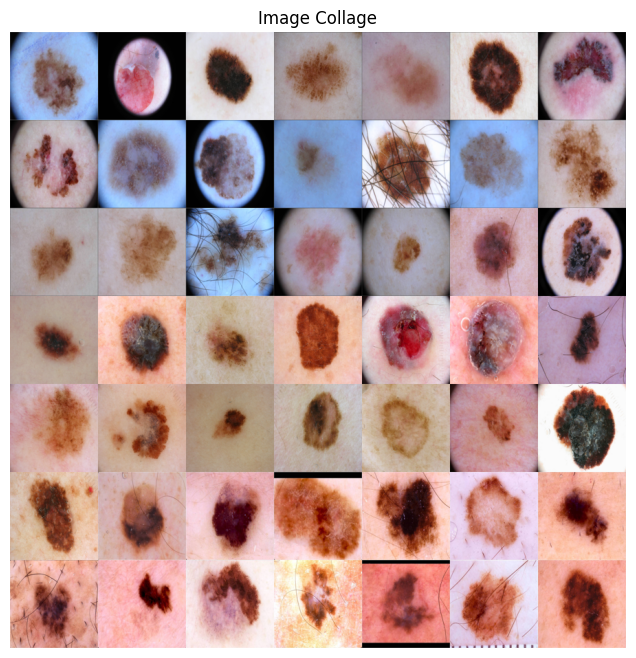

In [17]:
# ========================================
# SECTION 7 — COLLAGE
# ========================================
def make_collage(paths, grid=6, size=(128,128)):
    paths = paths[:grid*grid]
    imgs = [Image.open(p).convert("RGB").resize(size) for p in paths]
    collage = Image.new("RGB", (size[0]*grid, size[1]*grid))
    for i, im in enumerate(imgs):
        collage.paste(im, ((i%grid)*size[0], (i//grid)*size[1]))
    plt.figure(figsize=(8,8))
    plt.imshow(collage); plt.axis("off")
    plt.title("Image Collage")

make_collage(train_files, grid=7)

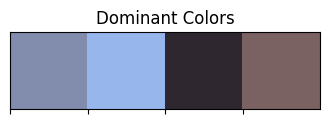

In [18]:
# ========================================
# SECTION 8 — DOMINANT COLOR (KMeans)
# ========================================
def dominant_colors(img_path, k=4):
    arr = np.array(Image.open(img_path).convert('RGB').resize((128,128))).reshape(-1,3)
    colors = KMeans(n_clusters=k, n_init=10).fit(arr).cluster_centers_
    sns.palplot(colors/255); plt.title("Dominant Colors")

dominant_colors(train_files[0])

In [ ]:
# Kekaburan (Blurriness)
# Sebagian besar gambar memiliki nilai variansi Laplacian yang sangat rendah (mendekati nol), yang mengindikasikan bahwa gambar tersebut kabur atau tidak fokus.
# Implikasi: Kekaburan ini dapat mengganggu pembelajaran model karena detail tepi dan struktur lesi yang krusial untuk diagnosis menjadi tidak jelas.

# 2. Isu Kontras
# Mayoritas gambar memiliki kontras yang rendah (deviasi standar piksel di bawah 20).
# Implikasi: Kontras yang kurang tajam mempersulit model untuk memisahkan lesi secara efektif dari latar belakang kulit.

# 3. Kecerahan
# Gambar umumnya cukup terang (rata-rata piksel di atas 140).
# Implikasi: Kecerahan yang seragam memvalidasi perlunya langkah normalisasi standar untuk menstandardisasi range nilai piksel.

100%|██████████| 300/300 [00:27<00:00, 10.99it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)

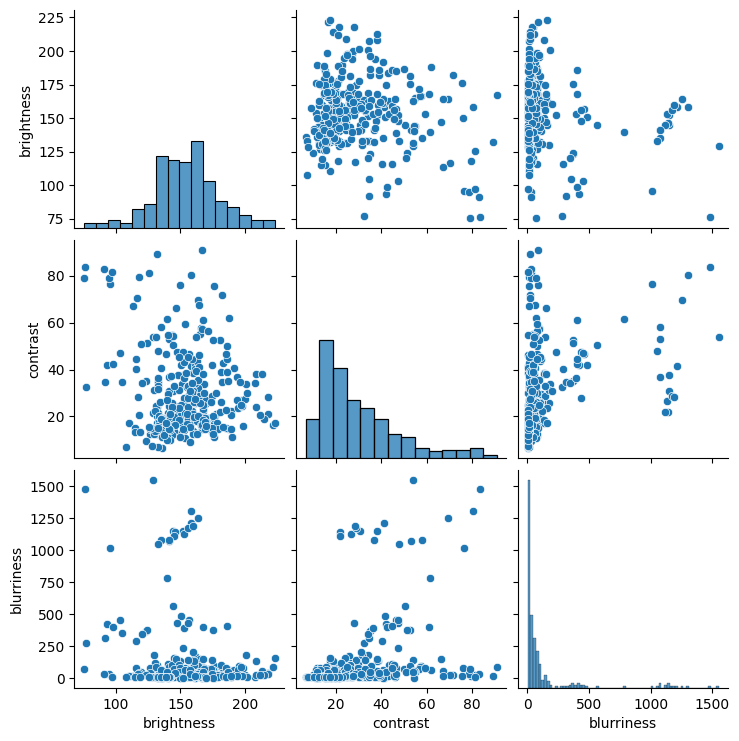

In [19]:
# ========================================
# SECTION 9 — QUALITY ANALYSIS
# ========================================
brightness, contrast, blur = [], [], []
for fp in tqdm(train_files[:300]):
    g = cv2.cvtColor(cv2.imread(str(fp)), cv2.COLOR_BGR2GRAY)
    brightness.append(g.mean())
    contrast.append(g.std())
    blur.append(cv2.Laplacian(g, cv2.CV_64F).var())

df_q = pd.DataFrame({"brightness": brightness, "contrast": contrast, "blurriness": blur})
sns.pairplot(df_q); plt.show()


In [ ]:
# Tumpang Tindih Kelas yang Luas
# Titik data dari Melanoma, Nevus, dan Seborrheic Keratosis tercampur secara luas di seluruh plot t-SNE dan PaCMAP.

# Implikasi: Fitur visual generik (dari MobileNetV2 yang dilatih di ImageNet) tidak cukup spesifik untuk membedakan lesi jinak (Nevus) dari lesi ganas (Melanoma).

# Tantangan Klasifikasi Utama
# Tumpang tindih yang signifikan antara Melanoma dan Nevus menunjukkan bahwa tugas klasifikasi inti akan menjadi sangat sulit bagi model.

In [21]:
# ========================================
# SECTION 11 — MOBILE NET EMBEDDINGS + TSNE/PACMAP
# ========================================
files, labels = [], []
for c in classes:
    fl = list((train_path/c).glob("*.jpg"))[:50]
    files.extend(fl)
    labels.extend([c]*len(fl))

model = MobileNetV2(include_top=False, pooling="avg")

def get_embedding(fp):
    x = np.expand_dims(preprocess_input(np.array(
        Image.open(fp).convert("RGB").resize((224,224)))), 0)
    return model.predict(x, verbose=0)[0]

emb = np.array([get_embedding(fp) for fp in tqdm(files)])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
df_tsne = pd.DataFrame(tsne.fit_transform(emb), columns=["x","y"])
df_tsne["label"] = labels
px.scatter(df_tsne, x="x", y="y", color="label", title="t-SNE Clusters").show()

pac = PaCMAP(n_components=2)
df_pac = pd.DataFrame(pac.fit_transform(emb), columns=["x","y"])
df_pac["label"] = labels
px.scatter(df_pac, x="x", y="y", color="label", title="PaCMAP Clusters").show()


/tmp/ipykernel_47/844949310.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(include_top=False, pooling="avg")
I0000 00:00:1765181219.502840      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/150 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1765181222.839140     164 service.cc:148] XLA service 0x7cc5cc026090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765181222.839898     164 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765181223.287262     164 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765181225.469693     164 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 150/150 [00:41<00:00,  3.60it/s]


## Data Processing & modelling

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from pathlib import Path
import random
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Batch size 16, karena data hanya 2000
# IMG_size 224 supaya bisa diterima efficientnet,ShuffleNetV2, MobileNetV3-Small

# class_dup_prob digunakan untuk menentukan setiap gambar di class itu ada kesempatan x5 untuk diduplikasi

In [23]:
train_dir = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train')
val_dir   = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid')
test_dir  = Path('/kaggle/input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test')

IMG_SIZE = 224
BATCH_SIZE = 16
CLASS_NAMES = ["melanoma", "nevus", "seborrheic_keratosis"]
NUM_CLASSES = len(CLASS_NAMES)

# Probability duplicate per-class
class_dup_prob = {0:0.45, 1:0.10, 2:0.55}


In [24]:
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

extra_augment = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomRotation(degrees=35),
    transforms.RandomAffine(degrees=0, shear=15, scale=(0.85,1.15)),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])



In [ ]:
# Inti dari DuplicateAugDataset adalah strategi oversampling berbasis probabilitas untuk mengatasi ketidakseimbangan kelas dan meningkatkan keragaman data selama pelatihan model.
# Ketika sebuah gambar diakses, ada kemungkinan (yang ditentukan per kelas melalui class_dup_prob) bahwa ia akan didapatkan dua kali dalam satu iterasi:

# Versi Pertama: Menerima transformasi standar (base_transform).
# Versi Kedua (Duplikat): Menerima transformasi yang lebih agresif (extra_augment). Tujuannya supaya model tidak melihat bahwa ini duplikasi tetapi gambar unik baru

In [25]:
class DuplicateAugDataset(Dataset):
    def __init__(self, root_dir, transform=None, extra_transform=None, class_dup_prob=None):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform
        self.extra_transform = extra_transform
        self.class_dup_prob = class_dup_prob
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.transform(img)
        
        # Decide duplication
        if random.random() < self.class_dup_prob[label]:
            dup = self.extra_transform(self.dataset[idx][0])
            return [img, dup], [label, label]
            
        return [img], [label]


In [26]:
def custom_collate(batch):
    images = []
    labels = []
    for imgs, lbls in batch:
        images.extend(imgs)
        labels.extend(lbls)
    return torch.stack(images), torch.tensor(labels)


In [ ]:
# Karena datanya imbalanced, tentukan class_weight dan focal loss sebagai parameter di pelatihan model supaya membantu menyeimbangkan.

In [27]:
labels_flat = []
dataset_tmp = datasets.ImageFolder(train_dir)
for _, label in dataset_tmp:
    labels_flat.append(label)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(labels_flat),
                                     y=labels_flat)

class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()
print("Class weights:", class_weights)


Class weights: tensor([1.7825, 0.4859, 2.6247], device='cuda:0')


In [ ]:
# Tujuan FocalLoss untuk memberikan bobot yang lebih besar pada sampel yang sulit diklasifikasikan (hard examples) dan sampel dari kelas minoritas, 
# sekaligus mengurangi kontribusi kerugian dari sampel yang mudah diklasifikasikan (easy examples) dan sampel dari kelas mayoritas.

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        focal = ((1 - pt) ** self.gamma) * ce_loss
        return focal.mean()


# Dataloader

In [ ]:
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


train_dataset = DuplicateAugDataset(train_dir, base_transform, extra_augment, class_dup_prob)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Modelling

In [ ]:
# Ketiga model ini memakai pretrain cnn biasa dan bukan transformer. 

# Kebutuhan Data Besar (Prasyarat Transformer): Arsitektur Transformer secara intrinsik membutuhkan data yang sangat besar untuk mencapai kinerja optimal. 
# Dengan dataset yang memiliki ketidakseimbangan kelas dan jumlah sampel yang terbatas (Melanoma hanya $n=374$), 
# model Transformer berisiko overfitting atau gagal belajar secara efektif tanpa data augmentation yang ekstensif.


# Masalah Resolusi dan Detail Halus: Transformer memecah gambar menjadi patch. 
# Jika detail penting lesi (seperti struktur retikular atau dots) terlalu kecil dan terpecah di batas patch, mekanisme attention mungkin kurang efektif menangkapnya.

## Model 1: EfficientNet (model cnn biasa)

In [30]:

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# Load pre-trained EfficientNet-B0
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

# Ganti classifier terakhir
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.cuda()


In [34]:
criterion = FocalLoss(alpha=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [ ]:
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    return val_loss/len(loader), correct/total


epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute Train Accuracy
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-----------------------------------------------------------")


Epoch 1/15
Train Loss: 0.4749 | Train Acc: 0.4157 | Val Loss: 0.4391 | Val Acc: 0.5533
-----------------------------------------------------------
Epoch 2/15
Train Loss: 0.3621 | Train Acc: 0.4800 | Val Loss: 0.4711 | Val Acc: 0.5200
-----------------------------------------------------------
Epoch 3/15
Train Loss: 0.2865 | Train Acc: 0.5130 | Val Loss: 0.4063 | Val Acc: 0.5600
-----------------------------------------------------------
Epoch 4/15
Train Loss: 0.2413 | Train Acc: 0.5452 | Val Loss: 0.3930 | Val Acc: 0.6333
-----------------------------------------------------------
Epoch 5/15
Train Loss: 0.2088 | Train Acc: 0.5742 | Val Loss: 0.3248 | Val Acc: 0.6600
-----------------------------------------------------------
Epoch 6/15
Train Loss: 0.1695 | Train Acc: 0.6147 | Val Loss: 0.2980 | Val Acc: 0.7067
-----------------------------------------------------------


In [42]:
# # Training tambahan 5 epoch
# additional_epochs = 5

# for epoch in range(additional_epochs):
#     model.train()
#     running_loss = 0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         images, labels = images.cuda(), labels.cuda()

#         optimizer.zero_grad()
#         outputs = model(images)
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Compute Train Accuracy
#         _, pred = torch.max(outputs, 1)
#         correct += (pred == labels).sum().item()
#         total += labels.size(0)

#     scheduler.step()

#     train_loss = running_loss / len(train_loader)
#     train_acc = correct / total

#     val_loss, val_acc = validate(model, val_loader)

#     print(f"Additional Epoch {epoch+1}/{additional_epochs}")
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
#           f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
#     print("-----------------------------------------------------------")


## Model 2: ShuffleNet_V2_X1_0_Weights (cnn biasa)

In [15]:
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [24]:
# =========================
# MODEL 2 : 
# =========================
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

# Load pre-trained ShuffleNetV2
weights2 = ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
model2 = shufflenet_v2_x1_0(weights=weights2)

# Ganti classifier terakhir
in_features = model2.fc.in_features
model2.fc = nn.Linear(in_features, NUM_CLASSES)
model2 = model2.cuda()

criterion2 = FocalLoss(alpha=class_weights)
optimizer2 = optim.AdamW(model2.parameters(), lr=3e-4)
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=10)



In [25]:
epochs = 15
for epoch in range(epochs):
    model2.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer2.zero_grad()
        outputs = model2(images)

        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    scheduler2.step()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    val_loss, val_acc = validate(model2, val_loader)

    print(f"[Model2] Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-----------------------------------------------------------")


[Model2] Epoch 1/15
Train Loss: 0.5614 | Train Acc: 0.2817 | Val Loss: 0.5152 | Val Acc: 0.3667
-----------------------------------------------------------
[Model2] Epoch 2/15
Train Loss: 0.3939 | Train Acc: 0.3259 | Val Loss: 0.4165 | Val Acc: 0.4067
-----------------------------------------------------------
[Model2] Epoch 3/15
Train Loss: 0.3650 | Train Acc: 0.3439 | Val Loss: 0.4046 | Val Acc: 0.4533
-----------------------------------------------------------
[Model2] Epoch 4/15
Train Loss: 0.2979 | Train Acc: 0.4001 | Val Loss: 0.4390 | Val Acc: 0.5667
-----------------------------------------------------------
[Model2] Epoch 5/15
Train Loss: 0.2850 | Train Acc: 0.4604 | Val Loss: 0.4392 | Val Acc: 0.5933
-----------------------------------------------------------
[Model2] Epoch 6/15
Train Loss: 0.2346 | Train Acc: 0.4961 | Val Loss: 0.3641 | Val Acc: 0.6400
-----------------------------------------------------------
[Model2] Epoch 7/15
Train Loss: 0.2143 | Train Acc: 0.5270 | Val

## Model 3: MobileNetV3-Small

In [19]:
# =========================
# MODEL 3 : MobileNetV3-Small
# =========================
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

weights3 = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model3 = mobilenet_v3_small(weights=weights3)

in_features = model3.classifier[3].in_features
model3.classifier[3] = nn.Linear(in_features, NUM_CLASSES)

model3 = model3.cuda()

criterion3 = FocalLoss(alpha=class_weights)
optimizer3 = optim.AdamW(model3.parameters(), lr=3e-4)
scheduler3 = optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=10)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 134MB/s]


In [20]:
epochs = 15

for epoch in range(epochs):
    model3.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer3.zero_grad()
        outputs = model3(images)

        loss = criterion3(outputs, labels)
        loss.backward()
        optimizer3.step()

        running_loss += loss.item()

        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    scheduler3.step()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    val_loss, val_acc = validate(model3, val_loader)

    print(f"[Model3] Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-----------------------------------------------------------")


[Model3] Epoch 1/15
Train Loss: 0.4817 | Train Acc: 0.3797 | Val Loss: 0.9303 | Val Acc: 0.6000
-----------------------------------------------------------
[Model3] Epoch 2/15
Train Loss: 0.3618 | Train Acc: 0.4819 | Val Loss: 0.4732 | Val Acc: 0.5933
-----------------------------------------------------------
[Model3] Epoch 3/15
Train Loss: 0.3185 | Train Acc: 0.4874 | Val Loss: 0.4086 | Val Acc: 0.5800
-----------------------------------------------------------
[Model3] Epoch 4/15
Train Loss: 0.2740 | Train Acc: 0.5467 | Val Loss: 0.4021 | Val Acc: 0.5533
-----------------------------------------------------------
[Model3] Epoch 5/15
Train Loss: 0.2408 | Train Acc: 0.5653 | Val Loss: 0.4056 | Val Acc: 0.5667
-----------------------------------------------------------
[Model3] Epoch 6/15
Train Loss: 0.2179 | Train Acc: 0.5722 | Val Loss: 0.4088 | Val Acc: 0.5867
-----------------------------------------------------------
[Model3] Epoch 7/15
Train Loss: 0.1795 | Train Acc: 0.6064 | Val

# Inference

In [ ]:
# Inference ini menggunakan teknik ensemble voting soft (yaitu ambil probabilitas dari ketiga model untuk voting)
# Alasan pakai voting soft daripada voting hard adalah dengan soft(probability), votingnya akan lebih jelas karena ada probabilitynya ketimbang dari voting hard.

In [26]:
from sklearn.metrics import classification_report

def soft_voting_predict(models, loader):
    for m in models:
        m.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda()

            # ambil probabilitas dari ketiga model
            probs = []
            for m in models:
                logits = m(images)
                prob = torch.softmax(logits, dim=1)
                probs.append(prob)

            # rata-rata probability (soft voting)
            avg_prob = torch.stack(probs).mean(dim=0)

            pred = avg_prob.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)


In [27]:
models = [model, model2, model3]   # model1, model2, model3 kamu
preds, labels = soft_voting_predict(models, test_loader)


In [ ]:
# Peningkatan Akurasi: Teknik Ensemble menghasilkan akurasi terbaik (57.33%) dan Weighted Average F1-score tertinggi (0.5913).
# Peningkatan Melanoma: Ensemble secara signifikan meningkatkan recall Melanoma menjadi 0.6581 (artinya menangkap hampir dua per tiga dari kasus Melanoma) dan sedikit meningkatkan precision Melanoma menjadi 0.4162.
# Peningkatan F1-score: F1-score Melanoma meningkat dari sekitar $0.43 - 0.48$ menjadi 0.5099 pada Ensemble, menunjukkan keseimbangan terbaik antara precision dan recall untuk kelas yang paling penting secara klinis.

In [28]:
print(classification_report(
    labels,
    preds,
    target_names=CLASS_NAMES,
    digits=4
))


                      precision    recall  f1-score   support

            melanoma     0.4162    0.6581    0.5099       117
               nevus     0.9442    0.4733    0.6305       393
seborrheic_keratosis     0.3716    0.9000    0.5260        90

            accuracy                         0.5733       600
           macro avg     0.5773    0.6771    0.5555       600
        weighted avg     0.7553    0.5733    0.5913       600



In [ ]:
# Model Individu Lemah: Semua model CNN individu menunjukkan keseimbangan yang buruk antara Precision dan Recall pada kelas minoritas (Melanoma dan Seborrheic Keratosis), 
# dengan Precision yang sangat rendah (sekitar 40%). Ini mengonfirmasi bahwa fitur antar kelas sangat ambigu.
    
# Kelas Kritis: Melanoma memiliki F1-score terendah pada model individu, menegaskan bahwa tugas klasifikasi kanker adalah yang paling menantang.

# Kinerja Ensemble: Penggabungan model adalah strategi terbaik, menghasilkan peningkatan kinerja yang jelas (F1-score Melanoma  0.50 dan Akurasi Keseluruhan tertinggi). 
# Ini menunjukkan bahwa model-model ini membuat kesalahan yang berbeda, yang dapat dikoreksi saat digabungkan.

In [29]:
def print_classification_report(model, loader, class_names, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda()
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(f"===== {model_name} Classification Report =====")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    ))
    print("-----------------------------------------------------------\n")

# Print untuk model 1 (EfficientNet-B0)
print_classification_report(model, test_loader, CLASS_NAMES, model_name="EfficientNet-B0")

# Print untuk model 2 (ShuffleNetV2)
print_classification_report(model2, test_loader, CLASS_NAMES, model_name="ShuffleNetV2")

# Print untuk model 3 (MobileNetV3-Small)
print_classification_report(model3, test_loader, CLASS_NAMES, model_name="MobileNetV3-Small")


===== EfficientNet-B0 Classification Report =====
                      precision    recall  f1-score   support

            melanoma     0.3485    0.5897    0.4381       117
               nevus     0.9385    0.4275    0.5874       393
seborrheic_keratosis     0.3677    0.9111    0.5240        90

            accuracy                         0.5317       600
           macro avg     0.5516    0.6428    0.5165       600
        weighted avg     0.7379    0.5317    0.5488       600

-----------------------------------------------------------

===== ShuffleNetV2 Classification Report =====
                      precision    recall  f1-score   support

            melanoma     0.4182    0.5897    0.4894       117
               nevus     0.9121    0.4224    0.5774       393
seborrheic_keratosis     0.3202    0.9000    0.4723        90

            accuracy                         0.5267       600
           macro avg     0.5501    0.6374    0.5130       600
        weighted avg     0.7270